# S5: Patient and age UMAP projections

In [1]:
from notebook_utils import *

# print modules and versions            
imports()

/home/ubuntu/py_36_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/ubuntu/py_36_env/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


pandas: 1.0.3
numpy: 1.18.2
scanpy.api: 1.4.4.post1
anndata: 0.6.22rc1
plotnine: 0.6.0
scipy: 1.4.1
more_itertools: 8.2.0
tqdm: 4.45.0
sklearn: 0.22.2.post1
lifelines: 0.24.3
matplotlib: 3.0.3


In [2]:
# import adata and associated files
wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data/local_data'

for file in ['raw_adata', 
             'full_adata',
             'DE_df',
            ]:
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
# for parallel processes
usable_cores = multiprocessing.cpu_count()-1

# update subtypes
full_adata.obs['subtypes'] = ['follicular' if x in ['light_foll_mel', 'dark_foll_mel', 'cyc_foll_mel'] \
                         else y \
                         for x,y in zip(full_adata.obs.class_1, full_adata.obs.subtypes)]

# label order
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['cutaneous','acral','foreskin','follicular']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
follicular_subtype_order = ['follicular','not_follicular']
dev_subtype_order = ['fet_acral','fet_cutaneous','fet_follicular','neo_foreskin','adt_acral','adt_cutaneous']

# create class_2 for site granularity
full_adata.obs['class_2'] = [x if x not in ['mel'] \
                             else f'{y}_mel'
                             for x,y in zip(full_adata.obs['class_1'], full_adata.obs['subtypes'])]

# create class_3 for site+dev_stage granularity
full_adata.obs['class_3'] = [x if not x.endswith('_mel') or x.startswith('cyc_') \
                             else f'{y}_{x}'
                             for x,y in zip(full_adata.obs['class_2'], full_adata.obs['dev_stage'])]

# update class_1 to pool by cell type
full_adata.obs['class_1'] = [x if not x.endswith('_mel') \
                             else 'mel' if not x.startswith('cyc_') \
                             else 'cyc_mel' \
                             for x in full_adata.obs['class_1']]
    
DE_df['class_1'] = (DE_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )
DE_df = DE_df.dropna()


## recluster on mels only

In [3]:
n_pcs = 75
coi = full_adata[[x in ['cutaneous_mel',
                'acral_mel',
                'foreskin_mel',
                'dark_foll_mel',
                'light_foll_mel',] for x in full_adata.obs.class_2]].obs.index.tolist()
raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
adata_subset2 = raw_adata[raw_adata.obs['recluster'] == True]
adata_subset2 = sc.pp.log1p(adata_subset2, copy=True) # new
sc.pp.highly_variable_genes(adata_subset2,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(adata_subset2) # new
sc.tl.pca(adata_subset2,svd_solver='arpack', use_highly_variable = True, n_comps=n_pcs, random_state=1) # new
sc.pp.neighbors(adata_subset2, n_pcs=n_pcs, n_neighbors=100, random_state=1) # new
sc.tl.umap(adata_subset2, min_dist = 0.5, random_state=1, init_pos='random')
sc.tl.louvain(adata_subset2, resolution = 0.25, random_state=1)

# add feature labels
for input_adata in [adata_subset2]:
    input_adata.obs['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 else np.nan for x in input_adata.obs.patient]
    input_adata.obs['true_year'] = [y+(9/12) if np.isnan(x) else x for x,y in zip(input_adata.obs['true_year'], input_adata.obs['age']) ]

    input_adata.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in input_adata.obs.age]
    input_adata.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in input_adata.obs.general_location]
    foll_idx = full_adata[[x in ['light_foll_mel','dark_foll_mel'] for x in full_adata.obs.class_2]].obs.index.tolist()
    input_adata.obs['subtypes'] = ['follicular' if x in foll_idx \
                                   else y for x,y in zip(input_adata.obs.index, input_adata.obs['subtypes'])]
    input_adata.obs['acral_subtype'] = [x if x == 'acral' else 'not_acral' for x in input_adata.obs['subtypes']]
    input_adata.obs['foreskin_subtype'] = [x if x == 'foreskin' else 'not_foreskin' for x in input_adata.obs['subtypes']]
    input_adata.obs['follicular_subtype'] = [x if x == 'follicular' else 'not_follicular' for x in input_adata.obs['subtypes']]

    input_adata.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(input_adata.obs.dev_stage, input_adata.obs.subtypes)]


    for i in ['dev_stage', 'subtypes', 'acral_subtype' ,'foreskin_subtype','follicular_subtype','dev_subtype']:
        input_adata.obs[i] =  (input_adata
                                 .obs[i]
                                 .astype(str)
                               .astype(CategoricalDtype(eval(f'{i}_order'), ordered = True))
                              )
            

## fetal ages

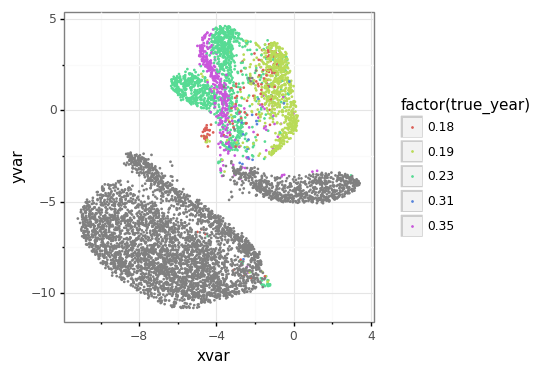

<ggplot: (-9223363254634975011)>


In [4]:
# plot
input_adata = adata_subset2
class_ref = 'true_year'

umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df[class_ref] = input_adata.obs[class_ref].values
umap_df[class_ref] = umap_df[class_ref].round(2)
umap_df[class_ref] = [np.nan if x >= 0.75 else x for x in umap_df[class_ref]]

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df[[not np.isnan(x) for x in umap_df[class_ref]]])
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('xvar','yvar',color=f'factor({class_ref})'), size = 0.1)
        + geom_point(umap_df[[np.isnan(x) for x in umap_df[class_ref]]],
                     aes('xvar','yvar'), size = 0.1,color='grey')
       )
print(plot)

## neonatal ages

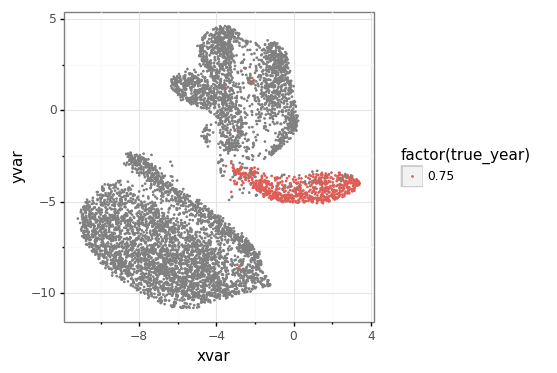

<ggplot: (-9223363254635410081)>


In [5]:
# plot
input_adata = adata_subset2
class_ref = 'true_year'

umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df[class_ref] = input_adata.obs[class_ref].values
umap_df[class_ref] = umap_df[class_ref].round(2)
umap_df[class_ref] = [np.nan if x != 0.75 else x for x in umap_df[class_ref]]

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df[[not np.isnan(x) for x in umap_df[class_ref]]])
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('xvar','yvar',color=f'factor({class_ref})'), size = 0.1)
        + geom_point(umap_df[[np.isnan(x) for x in umap_df[class_ref]]],
                     aes('xvar','yvar'), size = 0.1,color='grey')
       )
print(plot)


## adult ages

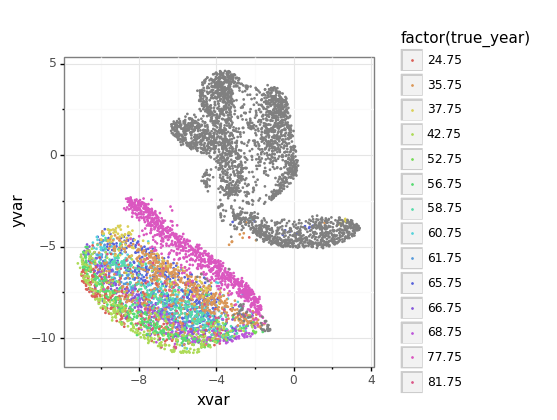

<ggplot: (8782216182627)>


In [6]:
# plot
input_adata = adata_subset2
class_ref = 'true_year'

umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df[class_ref] = input_adata.obs[class_ref].values
umap_df[class_ref] = umap_df[class_ref].round(2)
umap_df[class_ref] = [np.nan if x < 24.75 else x for x in umap_df[class_ref]]

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df[[not np.isnan(x) for x in umap_df[class_ref]]])
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('xvar','yvar',color=f'factor({class_ref})'), size = 0.1)
        + geom_point(umap_df[[np.isnan(x) for x in umap_df[class_ref]]],
                     aes('xvar','yvar'), size = 0.1,color='grey')
       )
print(plot)


## fetal patients

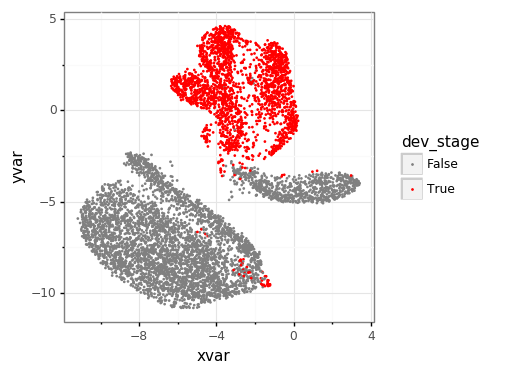

<ggplot: (-9223363254635277999)>


In [7]:
# plot
input_adata = adata_subset2
class_ref = 'dev_stage'

umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df[class_ref] = input_adata.obs[class_ref].values
umap_df[class_ref] = [x == 'fet' for x in umap_df[class_ref]]

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('xvar','yvar',color=class_ref), size = 0.1)
        + scale_color_manual(values = {True:'red', False:'grey'})
       )
print(plot)


## neonatal patients

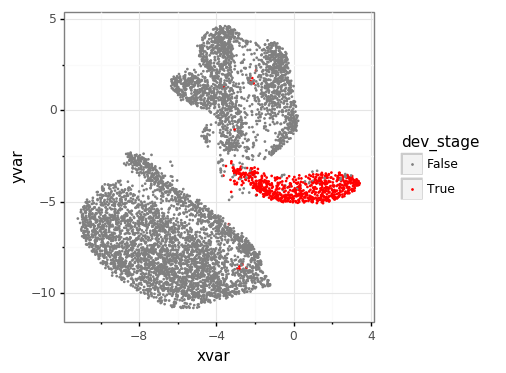

<ggplot: (8782219993597)>


In [8]:
# plot
input_adata = adata_subset2
class_ref = 'dev_stage'

umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df[class_ref] = input_adata.obs[class_ref].values
umap_df[class_ref] = [x == 'neo' for x in umap_df[class_ref]]

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('xvar','yvar',color=class_ref), size = 0.1)
        + scale_color_manual(values = {True:'red', False:'grey'})
       )
print(plot)


## adult patients

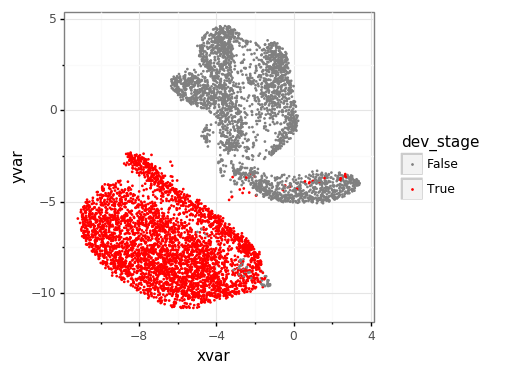

<ggplot: (8782219735770)>


In [9]:
# plot
input_adata = adata_subset2
class_ref = 'dev_stage'

umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df[class_ref] = input_adata.obs[class_ref].values
umap_df[class_ref] = [x == 'adt' for x in umap_df[class_ref]]

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('xvar','yvar',color=class_ref), size = 0.1)
        + scale_color_manual(values = {True:'red', False:'grey'})
       )
print(plot)
